In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd

init_ratings = pd.read_csv('/content/drive/MyDrive/MIR-Phase3-2/ratings.csv', sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

init_movies = pd.read_csv('/content/drive/MyDrive/MIR-Phase3-2/movies.csv', sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])

In [8]:
init_movies.head(5)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
init_ratings.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354


### Content Based

**Objective**: Build a Content-Based Recommendation system that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre.

**Dataset**:
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Split the `genres` column into separate genre strings.
   - Fill any missing values in the `genres` column and convert it to string.

2. **Compute TF-IDF Matrix**:
   - Use `TfidfVectorizer` to transform the genres into a TF-IDF matrix.

3. **Calculate Cosine Similarity**:
   - Compute cosine similarity between the TF-IDF matrices of movies.

4. **Recommend Movies**:
   - Create a function that gets movie recommendations based on the cosine similarity score of movie genres.

In [10]:
movies = init_movies.copy(deep=True)
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].fillna("").astype('str')

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])

In [12]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [21]:
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()
#define number of retrived movies
retriver_limit = 10
#can also define threshold on similarity
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #first one(idx 0) is itself
    sim_scores = sim_scores[1:1+retriver_limit]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]

In [22]:
# Example
genre_recommendations('GoldenEye (1995)')

345     Clear and Present Danger (1994)
543           Surviving the Game (1994)
724                    Rock, The (1996)
788                     Daylight (1996)
825               Chain Reaction (1996)
978                 Maximum Risk (1996)
1467                    Anaconda (1997)
1513                     Con Air (1997)
1693                   Firestorm (1998)
3686          Perfect Storm, The (2000)
Name: title, dtype: object


### Collaborative Filtering

**Objective**: Implement a collaborative filtering movie recommendation system to recommend movies to a user based on similar users' spreferences.

**Dataset**:

- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Split `genres` column into separate rows.

2. **Create User-Genre Matrix**:
   - Create a matrix where rows are users and columns are genres.
   - Each cell represents the ratio of movies watched by the user in that genre to the total movies watched by the user.

3. **Calculate User Similarity**:
   - Use cosine similarity to calculate the similarity between users.

4. **Find Top N Similar Users**:
   - Find the top N users with the most similar preferences to the given user.

5. **Recommend Movies**:
   - Recommend movies that similar users have watched but the target user has not.
   - Return titles and genres of the top 10 recommended movies.

In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [35]:
data = pd.merge(init_ratings, init_movies, on='movie_id')

In [36]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,1,1192,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,11,1192,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,14,1192,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,16,1192,One Flew Over the Cuckoo's Nest (1975),Drama


In [37]:
data = data.assign(genres=data['genres'].str.split('|')).explode('genres') #havent we done this before?

In [38]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,1,1192,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,11,1192,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,14,1192,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,16,1192,One Flew Over the Cuckoo's Nest (1975),Drama


In [39]:
grouped = data.groupby(['user_id', 'genres']).size().reset_index(name='count')
grouped.head(10)

,user_id,genres,count
0,1,Action,5
1,1,Adventure,5
2,1,Animation,18
3,1,Children's,20
4,1,Comedy,14
5,1,Crime,2
6,1,Drama,21
7,1,Fantasy,3
8,1,Musical,14
9,1,Romance,6


In [41]:
pivot_df = grouped.pivot(index='user_id', columns='genres', values='count').fillna(0)
pivot_df

genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,
1,5.0,5.0,18.0,20.0,14.0,2.0,0.0,21.0,3.0,0.0,0.0,14.0,0.0,6.0,3.0,3.0,2.0,0.0
2,56.0,19.0,0.0,0.0,25.0,12.0,0.0,79.0,1.0,1.0,2.0,0.0,3.0,24.0,17.0,31.0,15.0,3.0
3,23.0,25.0,3.0,3.0,30.0,0.0,0.0,8.0,2.0,0.0,3.0,1.0,1.0,5.0,6.0,5.0,2.0,6.0
4,19.0,6.0,0.0,1.0,0.0,1.0,0.0,6.0,2.0,0.0,3.0,0.0,0.0,2.0,9.0,4.0,3.0,2.0
5,31.0,9.0,4.0,6.0,56.0,21.0,6.0,104.0,0.0,3.0,10.0,3.0,8.0,30.0,15.0,39.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,154.0,83.0,34.0,54.0,261.0,53.0,11.0,372.0,19.0,17.0,74.0,31.0,34.0,122.0,169.0,147.0,42.0,14.0
6037,28.0,9.0,1.0,6.0,59.0,18.0,1.0,98.0,4.0,9.0,9.0,4.0,13.0,22.0,39.0,68.0,16.0,4.0
6038,2.0,1.0,3.0,1.0,12.0,0.0,0.0,9.0,0.0,0.0,2.0,0.0,0.0,6.0,1.0,0.0,4.0,0.0


In [42]:
total_counts = pivot_df.sum(axis=1)
normalized_df = pivot_df.div(total_counts, axis=0)
normalized_df

genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,
1,0.043103,0.043103,0.155172,0.172414,0.120690,0.017241,0.000000,0.181034,0.025862,0.000000,0.000000,0.120690,0.000000,0.051724,0.025862,0.025862,0.017241,0.000000
2,0.194444,0.065972,0.000000,0.000000,0.086806,0.041667,0.000000,0.274306,0.003472,0.003472,0.006944,0.000000,0.010417,0.083333,0.059028,0.107639,0.052083,0.010417
3,0.186992,0.203252,0.024390,0.024390,0.243902,0.000000,0.000000,0.065041,0.016260,0.000000,0.024390,0.008130,0.008130,0.040650,0.048780,0.040650,0.016260,0.048780
4,0.327586,0.103448,0.000000,0.017241,0.000000,0.017241,0.000000,0.103448,0.034483,0.000000,0.051724,0.000000,0.000000,0.034483,0.155172,0.068966,0.051724,0.034483
5,0.088068,0.025568,0.011364,0.017045,0.159091,0.059659,0.017045,0.295455,0.000000,0.008523,0.028409,0.008523,0.022727,0.085227,0.042614,0.110795,0.017045,0.002841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.091070,0.049083,0.020106,0.031934,0.154347,0.031342,0.006505,0.219988,0.011236,0.010053,0.043761,0.018332,0.020106,0.072147,0.099941,0.086931,0.024837,0.008279
6037,0.068627,0.022059,0.002451,0.014706,0.144608,0.044118,0.002451,0.240196,0.009804,0.022059,0.022059,0.009804,0.031863,0.053922,0.095588,0.166667,0.039216,0.009804
6038,0.048780,0.024390,0.073171,0.024390,0.292683,0.000000,0.000000,0.219512,0.000000,0.000000,0.048780,0.000000,0.000000,0.146341,0.024390,0.000000,0.097561,0.000000


In [44]:
user_similarity = cosine_similarity(normalized_df)

array([[1.        , 0.59392652, 0.52642667, ..., 0.69834932, 0.78068502,
        0.68939203],
       [0.59392652, 1.        , 0.66903366, ..., 0.70715636, 0.56343175,
        0.90698096],
       [0.52642667, 0.66903366, 1.        , ..., 0.68705058, 0.6779119 ,
        0.62134421],
       ...,
       [0.69834932, 0.70715636, 0.68705058, ..., 1.        , 0.81983412,
        0.86195747],
       [0.78068502, 0.56343175, 0.6779119 , ..., 0.81983412, 1.        ,
        0.71068362],
       [0.68939203, 0.90698096, 0.62134421, ..., 0.86195747, 0.71068362,
        1.        ]])

In [46]:
user_similarity_df = pd.DataFrame(user_similarity, index=normalized_df.index.values, columns=normalized_df.index.values)
user_similarity_df

,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
1,1.000000,0.593927,0.526427,0.345999,0.683741,0.804139,0.334192,0.634097,0.706181,0.789703,...,0.773599,0.819834,0.407116,0.187620,0.686592,0.721569,0.630877,0.698349,0.780685,0.689392
2,0.593927,1.000000,0.669034,0.770171,0.926928,0.644824,0.800366,0.951974,0.939869,0.763845,...,0.893203,0.772733,0.840031,0.309405,0.845356,0.916011,0.897834,0.707156,0.563432,0.906981
3,0.526427,0.669034,1.000000,0.665649,0.614157,0.672985,0.678774,0.484249,0.620163,0.862466,...,0.806012,0.724738,0.738403,0.176257,0.801695,0.724560,0.604351,0.687051,0.677912,0.621344
4,0.345999,0.770171,0.665649,1.000000,0.527271,0.376672,0.947039,0.584498,0.572512,0.579480,...,0.668976,0.454955,0.974503,0.165156,0.625503,0.636699,0.561714,0.337779,0.280647,0.510784
5,0.683741,0.926928,0.614157,0.527271,1.000000,0.723022,0.581497,0.949545,0.982931,0.817454,...,0.908946,0.888982,0.619386,0.369649,0.894214,0.963219,0.958866,0.828438,0.699646,0.985915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.721569,0.916011,0.724560,0.636699,0.963219,0.762135,0.655598,0.892141,0.950764,0.909171,...,0.968066,0.924787,0.699436,0.350342,0.965984,1.000000,0.960086,0.846474,0.756300,0.966636
6037,0.630877,0.897834,0.604351,0.561714,0.958866,0.651937,0.641761,0.892023,0.957598,0.801094,...,0.911222,0.845329,0.648755,0.456425,0.900900,0.960086,1.000000,0.757283,0.688530,0.940474
6038,0.698349,0.707156,0.687051,0.337779,0.828438,0.845347,0.349516,0.705967,0.799897,0.881496,...,0.853067,0.923806,0.421861,0.173897,0.859083,0.846474,0.757283,1.000000,0.819834,0.861957
6039,0.780685,0.563432,0.677912,0.280647,0.699646,0.907349,0.337471,0.533223,0.675536,0.874097,...,0.815025,0.866314,0.365294,0.288466,0.782290,0.756300,0.688530,0.819834,1.000000,0.710684


In [47]:
def get_top_n_similar_users(user_id, n=5):
    similar_users = user_similarity_df.loc[user_id].sort_values(ascending=False).head(n+1).index.tolist()
    similar_users.remove(user_id)  # Remove the user itself from the list
    return similar_users

In [51]:
def recommend_movies(user_id, n_similar_users=5, n_recommendations=10):
    top_similar_users = get_top_n_similar_users(user_id, n_similar_users)
    similar_users_data = data[data['user_id'].isin(top_similar_users)]

    # Movies watched by similar users but not by the target user
    target_user_watched = data[data['user_id'] == user_id]['movie_id'].unique()
    recommendations = similar_users_data[~similar_users_data['movie_id'].isin(target_user_watched)]

    top_recommendations = recommendations['movie_id'].value_counts().head(n_recommendations).index
    recommended_movies = init_movies[init_movies['movie_id'].isin(top_recommendations)]

    return recommended_movies[['title', 'genres']]

In [52]:
# Example
user_id = 1
recommended_movies = recommend_movies(user_id, n_similar_users=5, n_recommendations=10)

In [53]:
recommended_movies

,title,genres
33,Babe (1995),Children's|Comedy|Drama
900,Casablanca (1942),Drama|Romance|War
1019,Alice in Wonderland (1951),Animation|Children's|Musical
1262,Fantasia (1940),Animation|Children's|Musical
1575,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
2009,"Jungle Book, The (1967)",Animation|Children's|Comedy|Musical
2011,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance
2012,"Little Mermaid, The (1989)",Animation|Children's|Comedy|Musical|Romance
2018,Peter Pan (1953),Animation|Children's|Fantasy|Musical
2027,Sleeping Beauty (1959),Animation|Children's|Musical


### SVD (Singular Value Decomposition)



**Objective**: Implement an SVD-based recommendation system to recommend movies to users by decomposing the user-item interaction matrix into latent factors.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Create a user-item matrix where rows represent users, columns represent movies, and the values are the ratings.

2. **Decompose Matrix using SVD**:
   - Apply Singular Value Decomposition (SVD) to decompose the user-item matrix into three matrices: $U$, $\Sigma$, and $V^T$.

3. **Reconstruct Matrix**:
   - Reconstruct the user-item matrix using the top $k$ singular values to reduce dimensionality.

4. **Predict Ratings**:
   - Use the reconstructed matrix to predict ratings for all user-item pairs.

5. **Recommend Movies**:
   - Recommend the top 20 movies with the highest predicted ratings for a given user that the user hasn't rated yet.

In [54]:
ratings = init_ratings.copy(deep=True)
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6040 | Number of movies = 3706


Fill na elements.

In [55]:
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
Ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
from scipy.sparse.linalg import svds
import numpy as np

U, sigma, Vt = svds(Ratings.to_numpy(), k = 50)
sigma = np.diag(sigma)

In [58]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

In [59]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()
#as you can see user 1 has rated movie 1 5 in real life and it is predicted 4.3 here which is realistic

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.292556,0.164772,-0.184504,-0.018528,0.021516,-0.181793,-0.102936,0.157111,-0.058523,-0.164231,...,0.032475,0.007048,0.033170,-0.007577,-0.075329,0.394578,0.124714,0.051545,0.057349,0.076743
1,0.754817,0.128981,0.341128,0.009540,0.001830,1.314580,0.077427,0.062218,0.163983,1.514572,...,-0.051376,-0.015780,-0.010918,0.055628,-0.016037,0.166941,-0.421144,-0.106675,-0.049650,-0.126564
2,1.844858,0.473855,0.098573,-0.039309,-0.019895,-0.154038,-0.141531,0.111551,0.035977,0.738427,...,0.049994,0.003596,0.022734,0.043377,0.034825,0.120205,0.086553,0.034783,0.029337,-0.121871
3,0.395484,-0.045487,0.033716,0.083890,0.051561,0.260676,-0.081541,0.023891,0.051932,-0.077170,...,0.010847,0.007518,0.004269,0.009527,-0.079630,0.077845,0.051369,-0.017046,0.018980,-0.047580
4,1.557609,-0.006700,-0.044860,0.249014,-0.043320,1.518140,-0.164306,-0.043626,-0.078771,0.424064,...,0.097708,0.013847,-0.024256,-0.043126,-0.065997,-0.025571,0.517685,0.008508,0.106630,0.221219


In [60]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):

    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False)
    user_data = user_data = original_ratings[original_ratings['user_id'] == (userID)]

    # merfe movies data with user_data
    user_full = user_data.merge(movies, how = 'inner', on = 'movie_id').sort_values(['rating'], ascending=False)


    print(f'User {userID} has already rated {user_full.shape[0]} movies.')
    print(f'Recommending highest {num_recommendations} predicted ratings movies not already rated.')

    recommendations = (movies[~movies['movie_id'].isin(user_full['movie_id'])]
                       .merge(pd.DataFrame(sorted_user_predictions).reset_index(), how='left',
                              left_on='movie_id', right_on='movie_id')
                       .rename(columns={user_row_number: 'Predictions'})
                       .sort_values('Predictions', ascending=False)
                       .iloc[:num_recommendations, :-1])

    return user_full, recommendations

In [61]:
already_rated, predictions = recommend_movies(preds, 4375, movies, ratings, 20)

User 4375 has already rated 325 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [62]:
ratings.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354
5,1,1197,3,0,1196
6,1,1287,5,0,1286
7,1,2804,5,0,2803
8,1,594,4,0,593
9,1,919,4,0,918


In [63]:
# Top 20 movies that User 4375 has rated
already_rated.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
195,4375,3250,5,4374,3249,Alive (1993),['Drama']
285,4375,175,5,4374,174,Kids (1995),['Drama']
199,4375,3257,5,4374,3256,"Bodyguard, The (1992)","['Action', 'Drama', 'Romance', 'Thriller']"
65,4375,3809,5,4374,3808,What About Bob? (1991),['Comedy']
210,4375,2688,5,4374,2687,"General's Daughter, The (1999)","['Drama', 'Thriller']"
270,4375,150,5,4374,149,Apollo 13 (1995),['Drama']
271,4375,2710,5,4374,2709,"Blair Witch Project, The (1999)",['Horror']
125,4375,349,5,4374,348,Clear and Present Danger (1994),"['Action', 'Adventure', 'Thriller']"
60,4375,288,5,4374,287,Natural Born Killers (1994),"['Action', 'Thriller']"
141,4375,47,5,4374,46,Seven (Se7en) (1995),"['Crime', 'Thriller']"


#### Evaluation

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
ratings = init_ratings.copy(deep=True)

train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

train_ratings = train_data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
test_ratings = test_data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

R_train = train_ratings.values

user_ratings_mean_train = np.mean(R_train, axis=1)
Ratings_demeaned_train = R_train - user_ratings_mean_train.reshape(-1, 1)

U_train, sigma_train, Vt_train = svds(R_train, k = 50)
sigma_train = np.diag(sigma_train)

all_user_predicted_ratings_train = np.dot(np.dot(U_train, sigma_train), Vt_train)
preds_train = pd.DataFrame(all_user_predicted_ratings_train, columns=train_ratings.columns)

def predict_rating(user_id, movie_id):
    try:
      pred = preds_train.loc[user_id - 1][movie_id]
      return pred
    except:
      return 0
test_data['predicted_rating'] = test_data.apply(lambda x: predict_rating(x['user_id'], x['movie_id']), axis=1)

test_data.dropna(inplace=True)

rmse = sqrt(mean_squared_error(test_data['rating'], test_data['predicted_rating']))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 2.7407957185236764


### Nueral Network Model (Recommender Model)



**Objective**: Implement a Recommender model to recommend movies to a user based on similar users' preferences.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Define Dataset and DataLoader**:
   - Create a custom PyTorch `Dataset` for ratings.
   - Create a DataLoader for batching and shuffling data.

2. **Define the Neural Network**:
   - Create a neural network with embedding layers for users and movies.

3. **Train the Model**:
   - Train the model using Mean Squared Error loss and Adam optimizer.
   - Save model checkpoints.

4. **Evaluate the Model**:
   - Calculate RMSE on the entire dataset.

5. **Predict Ratings for Unrated Movies**:
   - Predict and recommend top 10 unrated movies for a given user.

In [65]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.optim as optim
from math import sqrt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [66]:
ratings = init_ratings.copy(deep=True)

In [69]:
# Check the maximum user_id and movie_id
max_user_id = ratings['user_id'].max()
max_movie_id = ratings['movie_id'].max()

print(f'Max user_id: {max_user_id}, Max movie_id: {max_movie_id}')

# Define the dataset
class RatingsDataset(Dataset):
    def __init__(self, ratings):
        self.users = ratings['user_id'].values
        self.movies = ratings['movie_id'].values
        self.ratings = ratings['rating'].values

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        user = self.users[idx] - 1  # Adjust to zero-based index
        movie = self.movies[idx] - 1  # Adjust to zero-based index
        rating = self.ratings[idx]
        return torch.tensor(user, dtype=torch.long), torch.tensor(movie, dtype=torch.long), torch.tensor(rating, dtype=torch.float)

# Define the neural network
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50):
        super(RecommenderNet, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, user, movie):
        user_emb = self.user_embedding(user)
        movie_emb = self.movie_embedding(movie)
        x = torch.cat([user_emb, movie_emb], dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the dataset and dataloader
dataset = RatingsDataset(ratings)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize the model, loss function, and optimizer
model = RecommenderNet(max_user_id, max_movie_id)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for user, movie, rating in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        optimizer.zero_grad()
        output = model(user, movie).squeeze()
        loss = criterion(output, rating)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_epoch_loss:.4f}')

    # Evaluation
    model.eval()
    all_users = torch.tensor(ratings['user_id'].values - 1, dtype=torch.long)  # Adjust to zero-based index
    all_movies = torch.tensor(ratings['movie_id'].values - 1, dtype=torch.long)  # Adjust to zero-based index
    all_ratings = torch.tensor(ratings['rating'].values, dtype=torch.float)
    with torch.no_grad():
        predictions = model(all_users, all_movies).squeeze()
    rmse = sqrt(mean_squared_error(all_ratings.numpy(), predictions.numpy()))
    print(f'RMSE after epoch {epoch+1}: {rmse:.4f}')
    model.train()

# Predict ratings for unrated movies
def predict_unrated_movies(user_id, model, ratings, movies, top_n=10):
    user_rated_movies = ratings[ratings['user_id'] == user_id]['movie_id'].tolist()
    unrated_movies = movies[~movies['movie_id'].isin(user_rated_movies)]

    user_tensor = torch.tensor([user_id - 1] * len(unrated_movies), dtype=torch.long)  # Adjust to zero-based index
    movie_tensor = torch.tensor(unrated_movies['movie_id'].values - 1, dtype=torch.long)  # Adjust to zero-based index

    with torch.no_grad():
        predictions = model(user_tensor, movie_tensor).squeeze()

    unrated_movies['predicted_rating'] = predictions.numpy()
    top_movies = unrated_movies.sort_values(by='predicted_rating', ascending=False).head(top_n)

    return top_movies

Max user_id: 6040, Max movie_id: 3952


Epoch 1/10: 100%|██████████| 15629/15629 [01:58<00:00, 131.49it/s]


Epoch 1/10, Average Loss: 0.9541
RMSE after epoch 1: 0.9171


Epoch 2/10: 100%|██████████| 15629/15629 [02:02<00:00, 127.76it/s]


Epoch 2/10, Average Loss: 0.8423
RMSE after epoch 2: 0.9016


Epoch 3/10: 100%|██████████| 15629/15629 [01:54<00:00, 135.98it/s]


Epoch 3/10, Average Loss: 0.8248
RMSE after epoch 3: 0.8955


Epoch 4/10: 100%|██████████| 15629/15629 [01:57<00:00, 133.33it/s]


Epoch 4/10, Average Loss: 0.8114
RMSE after epoch 4: 0.8860


Epoch 5/10: 100%|██████████| 15629/15629 [01:57<00:00, 133.53it/s]


Epoch 5/10, Average Loss: 0.7989
RMSE after epoch 5: 0.8820


Epoch 6/10: 100%|██████████| 15629/15629 [01:58<00:00, 132.45it/s]


Epoch 6/10, Average Loss: 0.7868
RMSE after epoch 6: 0.8752


Epoch 7/10: 100%|██████████| 15629/15629 [02:01<00:00, 128.36it/s]


Epoch 7/10, Average Loss: 0.7748
RMSE after epoch 7: 0.8656


Epoch 8/10: 100%|██████████| 15629/15629 [01:58<00:00, 131.71it/s]


Epoch 8/10, Average Loss: 0.7613
RMSE after epoch 8: 0.8576


Epoch 9/10: 100%|██████████| 15629/15629 [01:56<00:00, 134.56it/s]


Epoch 9/10, Average Loss: 0.7474
RMSE after epoch 9: 0.8462


Epoch 10/10: 100%|██████████| 15629/15629 [01:56<00:00, 134.36it/s]


Epoch 10/10, Average Loss: 0.7330
RMSE after epoch 10: 0.8405


In [73]:
# Example

sample_user_id = 1
sample_user_data = ratings[ratings['user_id'] == sample_user_id]
sample_dataset = RatingsDataset(sample_user_data)
sample_dataloader = DataLoader(sample_dataset, batch_size=1, shuffle=False)

print(f'Sample predictions for user ID {sample_user_id}:')
with torch.no_grad():
    for user, movie, rating in sample_dataloader:
        output = model(user, movie).squeeze()
        print(f'Movie ID: {movie.item()}, Predicted Rating: {min(max(output.item(), 0), 5):.3f}, Actual Rating: {rating.item()}')

Sample predictions for user ID 1:
Movie ID: 1192, Predicted Rating: 5.000, Actual Rating: 5.0
Movie ID: 660, Predicted Rating: 3.569, Actual Rating: 3.0
Movie ID: 913, Predicted Rating: 3.769, Actual Rating: 3.0
Movie ID: 3407, Predicted Rating: 4.231, Actual Rating: 4.0
Movie ID: 2354, Predicted Rating: 4.219, Actual Rating: 5.0
Movie ID: 1196, Predicted Rating: 4.324, Actual Rating: 3.0
Movie ID: 1286, Predicted Rating: 4.305, Actual Rating: 5.0
Movie ID: 2803, Predicted Rating: 4.491, Actual Rating: 5.0
Movie ID: 593, Predicted Rating: 4.244, Actual Rating: 4.0
Movie ID: 918, Predicted Rating: 4.420, Actual Rating: 4.0
Movie ID: 594, Predicted Rating: 4.594, Actual Rating: 5.0
Movie ID: 937, Predicted Rating: 4.044, Actual Rating: 4.0
Movie ID: 2397, Predicted Rating: 4.120, Actual Rating: 4.0
Movie ID: 2917, Predicted Rating: 4.463, Actual Rating: 4.0
Movie ID: 1034, Predicted Rating: 4.558, Actual Rating: 5.0
Movie ID: 2790, Predicted Rating: 4.028, Actual Rating: 4.0
Movie ID: 26

In [75]:
def predict_unrated_movies(user_id, model, ratings, movies, top_n=10):
    # Filter out movies already rated by the user
    user_rated_movies = ratings[ratings['user_id'] == user_id]['movie_id'].tolist()
    unrated_movies = movies[~movies['movie_id'].isin(user_rated_movies)]

    # Prepare tensors for prediction
    user_tensor = torch.tensor([user_id - 1] * len(unrated_movies), dtype=torch.long)  # Adjust to zero-based index
    movie_tensor = torch.tensor(unrated_movies['movie_id'].values - 1, dtype=torch.long)  # Adjust to zero-based index

    # Predict ratings for unrated movies
    with torch.no_grad():
        predictions = model(user_tensor, movie_tensor).squeeze()

    # Add predicted ratings to unrated_movies DataFrame
    unrated_movies['predicted_rating'] = predictions.numpy()

    # Recommend top movies with highest predicted ratings
    top_movies = unrated_movies.sort_values(by='predicted_rating', ascending=False).head(top_n)

    return top_movies

# Example
user_id = 1
predictions = predict_unrated_movies(user_id, model, ratings, movies)
predictions

<ipython-input-75-ac0f761daf9a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unrated_movies['predicted_rating'] = predictions.numpy()


,movie_id,title,genres,predicted_rating
52,53,Lamerica (1994),['Drama'],5.248565
2434,2503,"Apple, The (Sib) (1998)",['Drama'],5.201475
1217,1236,Trust (1990),"['Comedy', 'Drama']",5.121703
2836,2905,Sanjuro (1962),"['Action', 'Adventure']",4.998921
2502,2571,"Matrix, The (1999)","['Action', 'Sci-Fi', 'Thriller']",4.978524
2750,2819,Three Days of the Condor (1975),['Thriller'],4.956536
2288,2357,Central Station (Central do Brasil) (1998),['Drama'],4.955682
3509,3578,Gladiator (2000),"['Action', 'Drama']",4.944276
1252,1272,Patton (1970),"['Drama', 'War']",4.940546
1207,1225,Amadeus (1984),['Drama'],4.900280


### GMM (Gaussian Mixture Model)

**Objective**: Use a Gaussian Mixture Model to analyze and cluster the click data based on the number of clicks from different locations, aiming to identify distinct patterns of user behavior across 10 countries.

**Dataset**:
- **Click Data**: DataFrame with columns `link_id`, `location`, and `number_of_clicks`.

**Steps**:

1. **Preprocess Data**:
   - Ensure the dataset contains 10 distinct countries.
   - Create a matrix where rows represent different links and columns represent the number of clicks from each country.
   - Normalize the number of clicks to account for different scales.

2. **Fit GMM**:
   - Apply a Gaussian Mixture Model (GMM) to the click data matrix to identify clusters of links with similar click patterns across different countries.

3. **Evaluate Model**:
   - Analyze the resulting model by calculating the log lokelihood, BIC and AIC metrics.


In [86]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/MIR-Phase3-2/gmm-dataset.csv'
df = pd.read_csv(file_path)
print(df.shape)
df.head(10)

(100, 11)


,URL,United States,China,India,Japan,Brazil,Russia,Indonesia,Germany,United Kingdom,France
0,url_1,657,194,310,790,768,436,189,973,448,335
1,url_2,389,149,354,729,629,937,345,967,764,104
2,url_3,979,475,509,769,270,705,113,931,977,213
3,url_4,524,699,692,694,473,160,484,37,956,899
4,url_5,767,661,319,572,399,401,277,596,631,203
5,url_6,528,948,956,667,743,54,100,992,477,320
6,url_7,757,648,319,39,947,742,905,994,881,827
7,url_8,0,535,510,46,663,659,149,348,594,672
8,url_9,369,47,967,303,882,318,132,648,113,822
9,url_10,649,888,553,203,993,300,197,21,365,77


In [88]:
click_matrix = df.drop(columns=['URL'])
click_matrix_normalized = click_matrix.div(click_matrix.sum(axis=0), axis=1)
click_matrix_normalized

,United States,China,India,Japan,Brazil,Russia,Indonesia,Germany,United Kingdom,France
0,0.013123,0.003778,0.005957,0.014886,0.015033,0.009308,0.003916,0.020918,0.009637,0.006397
1,0.007770,0.002901,0.006803,0.013737,0.012312,0.020003,0.007148,0.020789,0.016435,0.001986
2,0.019554,0.009249,0.009782,0.014491,0.005285,0.015051,0.002341,0.020015,0.021017,0.004067
3,0.010466,0.013611,0.013298,0.013077,0.009258,0.003416,0.010028,0.000795,0.020565,0.017166
4,0.015320,0.012871,0.006130,0.010778,0.007810,0.008561,0.005739,0.012813,0.013574,0.003876
...,...,...,...,...,...,...,...,...,...,...
95,0.010366,0.013358,0.016046,0.001187,0.010903,0.002818,0.004828,0.004257,0.005055,0.012106
96,0.003136,0.014507,0.004958,0.006934,0.013741,0.003202,0.007438,0.004515,0.014714,0.012851
97,0.019574,0.010476,0.008532,0.012380,0.002192,0.010140,0.003419,0.005353,0.009530,0.007753
98,0.012444,0.013552,0.013317,0.010345,0.010354,0.012275,0.019767,0.010362,0.013079,0.015868


In [102]:
n_components = 3
gmm = GaussianMixture(n_components=n_components, random_state=42)

gmm.fit(click_matrix_normalized)

cluster_labels = gmm.predict(click_matrix_normalized)

log_likelihood = gmm.score(click_matrix_normalized)
bic = gmm.bic(click_matrix_normalized)
aic = gmm.aic(click_matrix_normalized)

print(f"Log-Likelihood: {log_likelihood}")
print(f"BIC: {bic}")
print(f"AIC: {aic}")

Log-Likelihood: 38.688014516222445
BIC: -6830.384376604836
AIC: -7343.602903244489


<Figure size 1000x600 with 0 Axes>

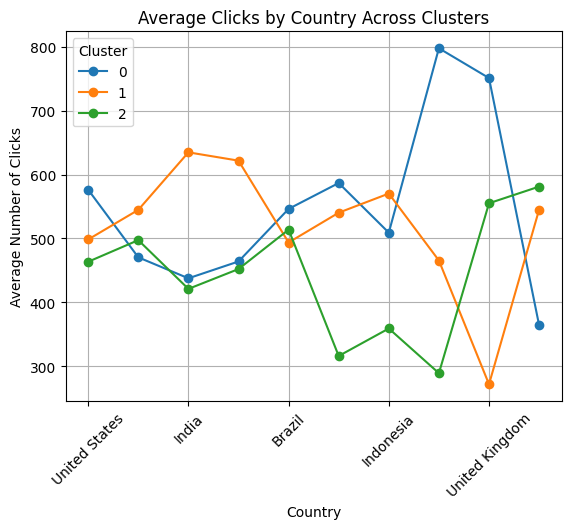

In [103]:
click_matrix_with_clusters = click_matrix.copy()
click_matrix_with_clusters['Cluster'] = cluster_labels
mean_clicks_by_cluster = click_matrix_with_clusters.groupby('Cluster').mean()
plt.figure(figsize=(10, 6))
mean_clicks_by_cluster.T.plot(marker='o')
plt.title('Average Clicks by Country Across Clusters')
plt.xlabel('Country')
plt.ylabel('Average Number of Clicks')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()